In [1]:
import pandas as pd

path = '/kaggle/input/electricity-data/electricity.csv'

df = pd.read_csv(path)
df

,Time,Demand,Temperature,Date,Holiday
0,2011-12-31T13:00:00Z,4382.825174,21.40,2012-01-01,True
1,2011-12-31T13:30:00Z,4263.365526,21.05,2012-01-01,True
2,2011-12-31T14:00:00Z,4048.966046,20.70,2012-01-01,True
3,2011-12-31T14:30:00Z,3877.563330,20.55,2012-01-01,True
4,2011-12-31T15:00:00Z,4036.229746,20.40,2012-01-01,True
...,...,...,...,...,...
52603,2014-12-31T10:30:00Z,3873.448714,19.00,2014-12-31,False
52604,2014-12-31T11:00:00Z,3791.637322,18.50,2014-12-31,False
52605,2014-12-31T11:30:00Z,3724.835666,17.70,2014-12-31,False
52606,2014-12-31T12:00:00Z,3761.886854,17.30,2014-12-31,False


In [2]:
df.columns = map(str.lower, df.columns)
df.columns

Index(['time', 'demand', 'temperature', 'date', 'holiday'], dtype='object')

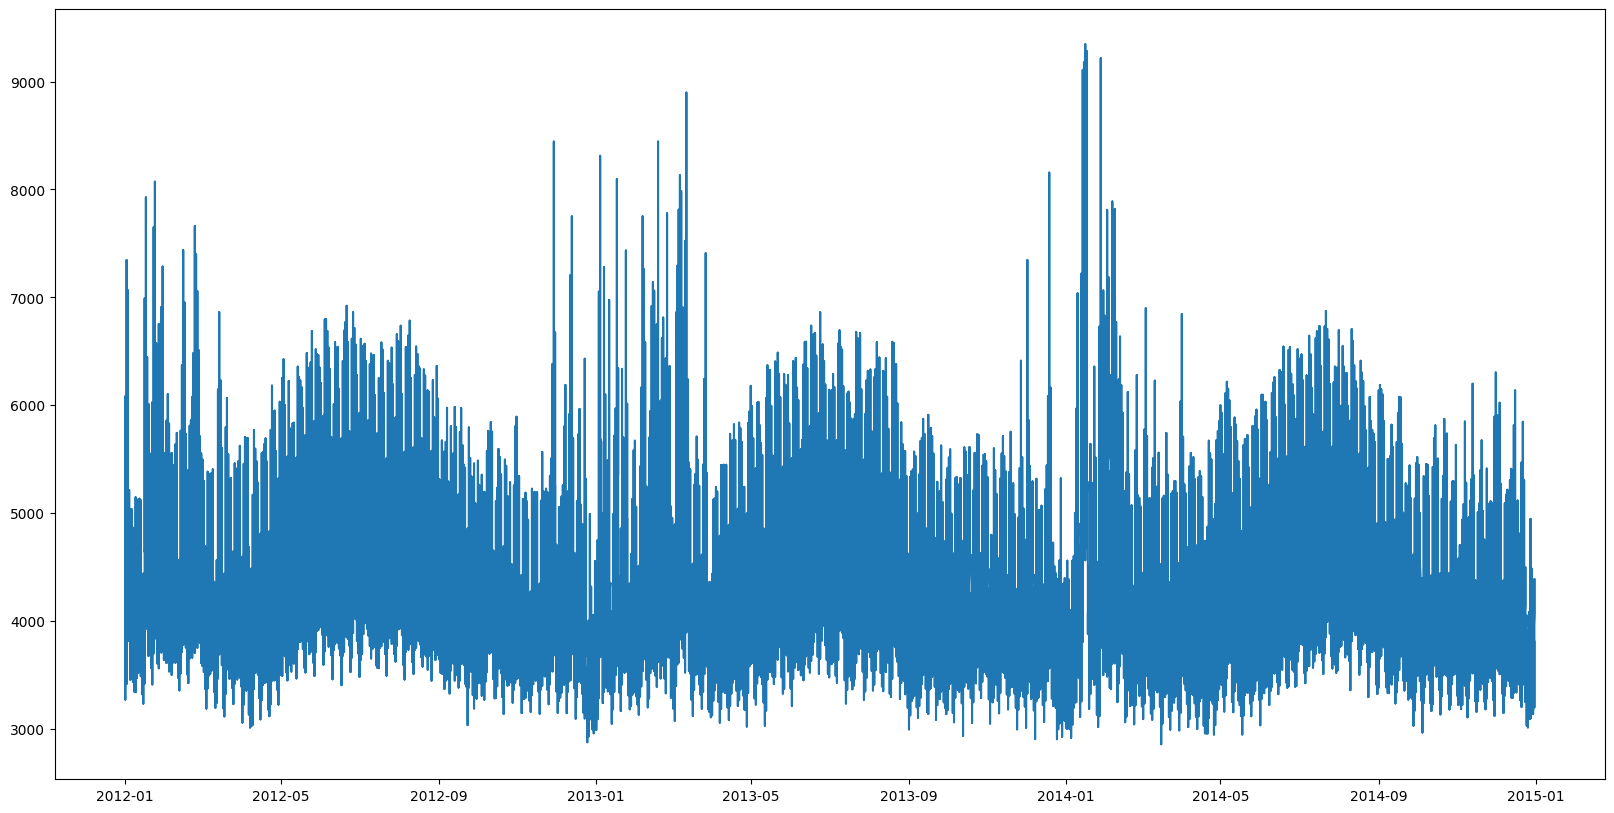

In [3]:
import matplotlib.pyplot as plt

df['date'] = pd.to_datetime(df['date'])

plt.figure(figsize=(20, 10))
plt.plot(df['date'], df['demand'])
plt.show()

In [4]:
df.index = df['date']
df.drop('date', axis=1, inplace=True)
df.drop('time', axis=1, inplace=True)
df

,demand,temperature,holiday
date,,,
2012-01-01,4382.825174,21.40,True
2012-01-01,4263.365526,21.05,True
2012-01-01,4048.966046,20.70,True
2012-01-01,3877.563330,20.55,True
2012-01-01,4036.229746,20.40,True
...,...,...,...
2014-12-31,3873.448714,19.00,False
2014-12-31,3791.637322,18.50,False
2014-12-31,3724.835666,17.70,False


In [5]:
train_ratio = 0.8

train_data = df[:int(len(df) * train_ratio)]
test_data = df[int(len(df) * train_ratio):]

train_data.shape, test_data.shape

((42086, 3), (10522, 3))

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train_data_transform = scaler.fit_transform(train_data)
test_data_transform = scaler.transform(test_data)

train_data_transform

array([[0.23506485, 0.47596154, 1.        ],
       [0.21664978, 0.46754808, 1.        ],
       [0.18359944, 0.45913462, 1.        ],
       ...,
       [0.38250203, 0.45432692, 0.        ],
       [0.4217747 , 0.44471154, 0.        ],
       [0.45477165, 0.4375    , 0.        ]])

In [7]:
train_data_transform.shape, test_data_transform.shape

((42086, 3), (10522, 3))

In [8]:
import numpy as np

n_past = 32

def create_X_y_data(data, n_past):
    X = []
    y = []

    for i in range(n_past, len(data)):
        X.append(data[i - n_past:i, 0:data.shape[1]])
        y.append(data[i,0])

    return np.array(X), np.array(y)

X_train, y_train = create_X_y_data(train_data_transform, n_past)
X_test, y_test = create_X_y_data(test_data_transform, n_past)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((42054, 32, 3), (42054,), (10490, 32, 3), (10490,))

In [9]:
train_data_transform[0:32, 0:3]

array([[0.23506485, 0.47596154, 1.        ],
       [0.21664978, 0.46754808, 1.        ],
       [0.18359944, 0.45913462, 1.        ],
       [0.15717718, 0.45552885, 1.        ],
       [0.1816361 , 0.45192308, 1.        ],
       [0.15533257, 0.44831731, 1.        ],
       [0.12889539, 0.44471154, 1.        ],
       [0.10847412, 0.43269231, 1.        ],
       [0.08865183, 0.42067308, 1.        ],
       [0.0773112 , 0.41706731, 1.        ],
       [0.07297568, 0.41346154, 1.        ],
       [0.06885948, 0.40985577, 1.        ],
       [0.06384414, 0.40625   , 1.        ],
       [0.06444405, 0.41466346, 1.        ],
       [0.07900011, 0.42307692, 1.        ],
       [0.09811418, 0.44471154, 1.        ],
       [0.11132094, 0.46634615, 1.        ],
       [0.13288602, 0.50360577, 1.        ],
       [0.1620696 , 0.54086538, 1.        ],
       [0.19032054, 0.56730769, 1.        ],
       [0.21382252, 0.59375   , 1.        ],
       [0.23972792, 0.62740385, 1.        ],
       [0.

In [10]:
train_data_transform[1:33, 0:3][-1,0] == train_data_transform[32,0]

True

#### Construct model

In [11]:
import torch
import torch.nn as nn

class Model(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(Model, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = self.dropout(lstm_out)
        x = self.linear(x)
        return x

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [13]:
input_size = 3
output_size = 1
hidden_size = 256
batch_size = 32
num_epochs = 10

model = Model(input_size, output_size, hidden_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

#### Create batch data (same as DataLoaders pytorch)

In [14]:
# Số lượng batches sẽ là tổng số mẫu chia cho batch size
number_of_batches_train = X_train.shape[0] // batch_size
number_of_batches_test = X_test.shape[0] // batch_size

# Thay đổi kích thước của X_train để thêm batch size
X_train_batches = X_train[:number_of_batches_train * batch_size].reshape(number_of_batches_train, batch_size, 32, 3)
y_train_batches = y_train[:number_of_batches_train * batch_size].reshape(number_of_batches_train, batch_size, 1)
X_test_batches = X_test[:number_of_batches_test * batch_size].reshape(number_of_batches_test, batch_size, 32, 3)
y_test_batches = y_test[:number_of_batches_test * batch_size].reshape(number_of_batches_test, batch_size, 1)
print(X_train_batches.shape)
print(X_test_batches.shape)
print(y_train_batches.shape)
print(y_test_batches.shape)

(1314, 32, 32, 3)
(327, 32, 32, 3)
(1314, 32, 1)
(327, 32, 1)


In [15]:
# print(y_train_batches[0])
# print(y_train[0:32])

In [16]:
def train_one_epoch(X_train_batches, y_train_batches, model, criterion, optimizer, epoch):
    running_loss = 0

    for i, data in enumerate(X_train_batches):
        labels = y_train_batches[i]

        data = torch.tensor(data, dtype=torch.float32).to(device)
        labels = torch.tensor(labels, dtype=torch.float32).to(device)

        pred = model(data)

        loss = criterion(pred[-1], labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(X_train)
    print(f'Epoch [{epoch+1}],Loss:{avg_loss}')

    return avg_loss

In [17]:
# train_one_epoch(X_train_batches, y_train_batches, model, criterion, optimizer, epoch=0)

In [18]:
def train(X_train_batches, y_train_batches, model, criterion, optimizer, num_epochs):
    loss_history = []
    for epoch in range(num_epochs):
        model.train(True)

        avg_loss = train_one_epoch(X_train_batches, y_train_batches, model, criterion, optimizer, epoch)

        loss_history.append(avg_loss)

    return loss_history

loss_history = train(X_train_batches, y_train_batches, model, criterion, optimizer, num_epochs)

Epoch [1],Loss:9.614122788751927e-05
Epoch [2],Loss:1.6930151628845295e-05
Epoch [3],Loss:1.1163294580768197e-05
Epoch [4],Loss:9.832247177842676e-06
Epoch [5],Loss:8.643036605606918e-06
Epoch [6],Loss:7.603199582677427e-06
Epoch [7],Loss:7.171391059137673e-06
Epoch [8],Loss:6.399873395397385e-06
Epoch [9],Loss:6.155651011954098e-06
Epoch [10],Loss:5.716240068180865e-06


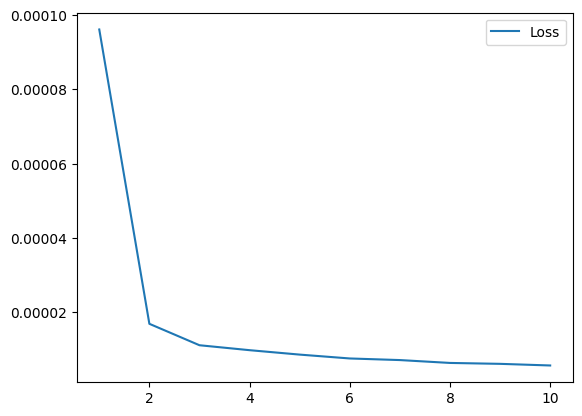

In [19]:
import matplotlib.pyplot as plt

plt.plot(list(range(1, 11)), loss_history, label="Loss")
plt.legend()
plt.show()

In [20]:
model.eval()

Model(
  (lstm): LSTM(3, 256)
  (linear): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [21]:
predictions = []

with torch.no_grad():
    i = 0
    for data_test in X_test:
        data = torch.tensor(data_test, dtype=torch.float32).to(device)
        pred = model(data)
        predictions.append(pred[-1].item())
        i+=1

predictions[:10]

[0.37251967191696167,
 0.3772987723350525,
 0.37315833568573,
 0.3719716966152191,
 0.37452155351638794,
 0.3741101026535034,
 0.38078320026397705,
 0.3796010911464691,
 0.36649373173713684,
 0.35259947180747986]

In [22]:
from sklearn.metrics import r2_score

r2_score(y_test, predictions)

0.990756608175417

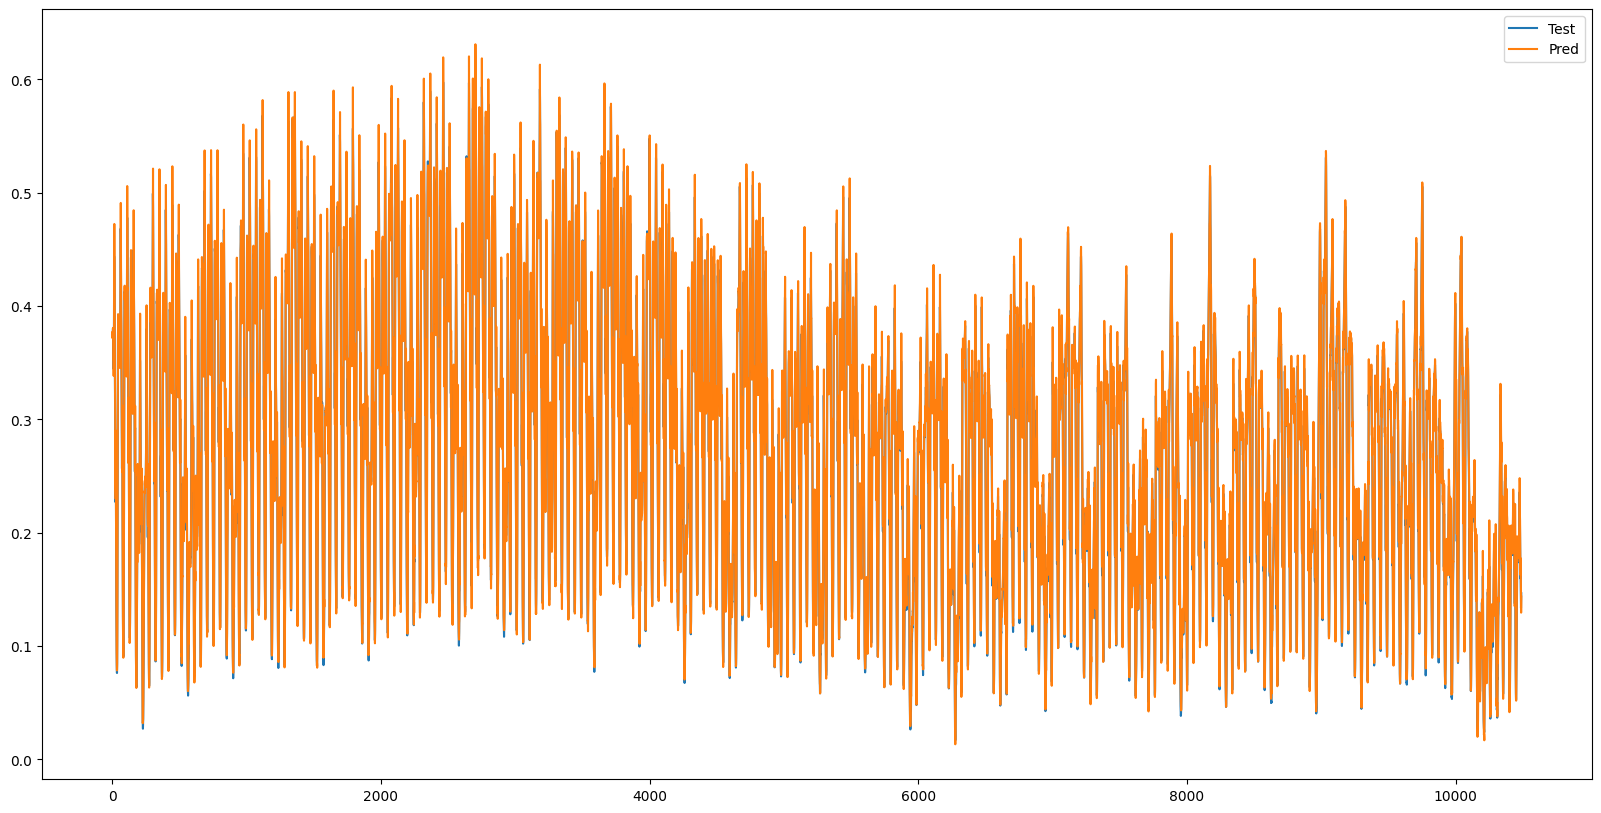

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(y_test, label="Test")
plt.plot(predictions, label="Pred")
plt.legend()
plt.show()

In [24]:
len(predictions), len(y_test), len(test_data)

(10490, 10490, 10522)

#### Expand dimension of predictions
Repeating A the number of times given by reps => np.tile

In [25]:
preds = np.array(predictions).reshape(-1, 1)
preds_broadcast = np.tile(preds, (1, 3))

preds_broadcast

array([[0.37251967, 0.37251967, 0.37251967],
       [0.37729877, 0.37729877, 0.37729877],
       [0.37315834, 0.37315834, 0.37315834],
       ...,
       [0.14012218, 0.14012218, 0.14012218],
       [0.12955321, 0.12955321, 0.12955321],
       [0.14376853, 0.14376853, 0.14376853]])

#### Inverse Transform MinmaxScaler of "predictions"

In [26]:
pred_test = scaler.inverse_transform(preds_broadcast)
pred_test = pred_test[:,0]

pred_test

array([5274.50267608, 5305.50498064, 5278.64572539, ..., 3766.92649231,
       3698.36501952, 3790.5806359 ])

#### Concat with first 32 items of test_data

In [27]:
pred_test_append_list = np.concatenate([test_data['demand'].values[0:32], pred_test])
pred_test_append_list, len(pred_test_append_list)

(array([5731.09196   , 5580.51463   , 5391.991986  , ..., 3766.92649231,
        3698.36501952, 3790.5806359 ]),
 10522)

### Plot train, test and prediction

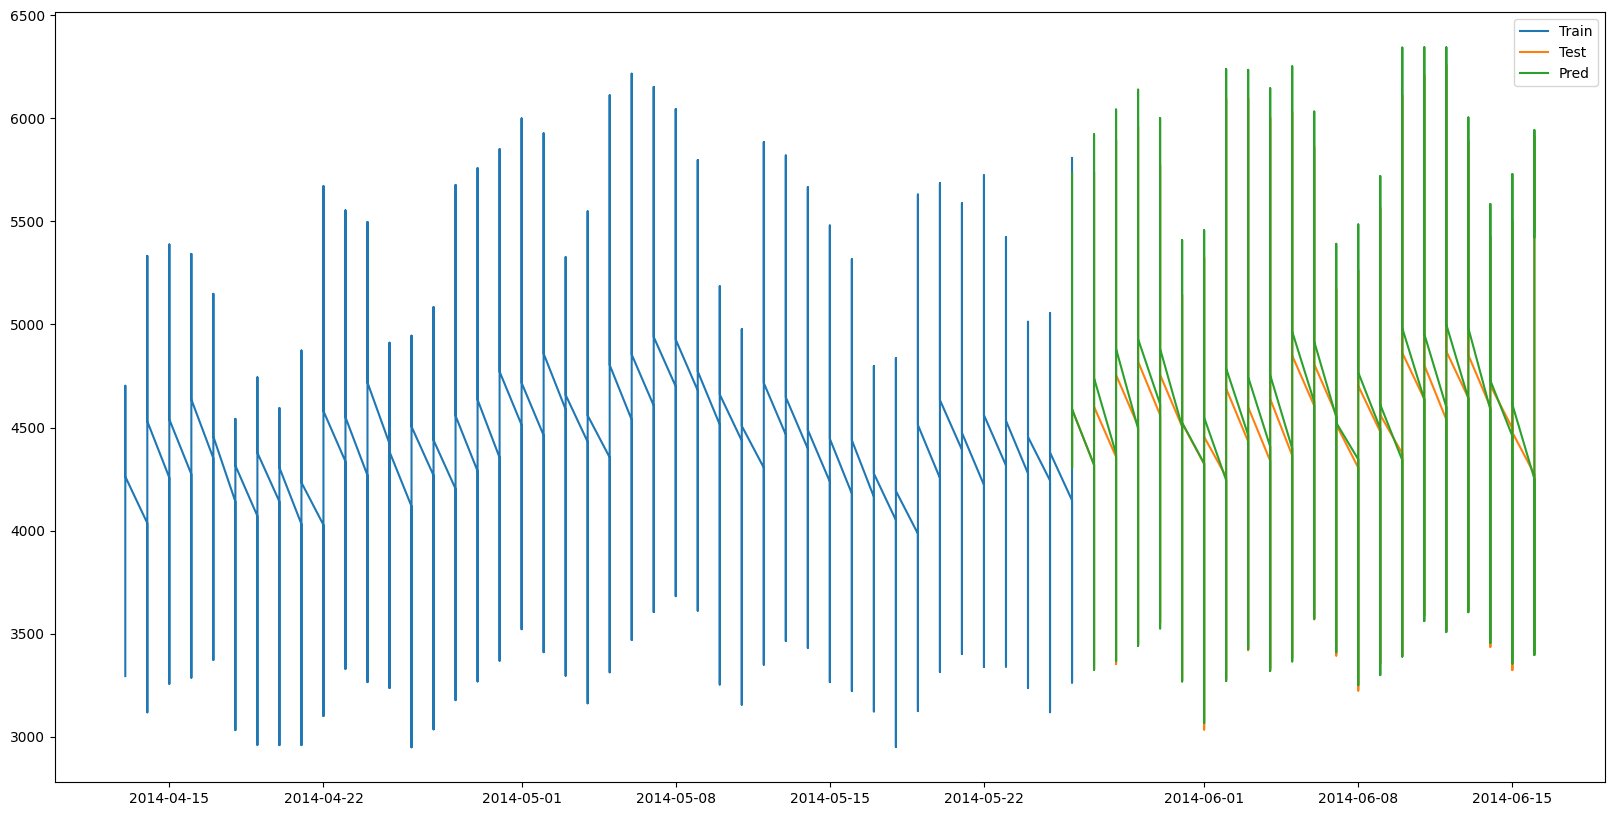

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(pd.to_datetime(train_data['demand'][40000:].index), train_data['demand'][40000:], label="Train")
plt.plot(pd.to_datetime(test_data['demand'][:1000].index), test_data['demand'][:1000], label="Test")
plt.plot(pd.to_datetime(test_data['demand'][:1000].index), pred_test_append_list[:1000], label="Pred")
plt.legend()
plt.show()